# MLB Salary Prediction (Part 2): EDA and Modeling

Click [here](./data_cleaning.ipynb) to see __Part 1: Data Wrangling__

## four assumptions:
1. __Linearity:__ 
2. __Homoscedasticity:__ 
3. __Independence:__ 
4. __Normality:__ 

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from statsmodels.formula.api import ols
from scipy import stats
import math
import seaborn as sns
import numpy as np
import pandas as pd
import csv

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

In [2]:
data_df = pd.read_csv('data/data_cleaned.csv')
data_df.reset_index(drop=False, inplace=True)
print(data_df.shape)
data_df.head()

(561, 36)


index  IDfg             Name  Age    G    PA    AB    R    H   1B   2B  3B  \
0      0  5677       A.J. Ellis   35  468  1713  1448  143  341  241   63   2   
1      1   746  A.J. Pierzynski   36  664  2587  2424  254  682  479  122   7   
2      2   746  A.J. Pierzynski   35  664  2628  2455  272  695  489  129   7   
3      3   746  A.J. Pierzynski   37  628  2414  2258  222  616  431  112   7   
4      4   746  A.J. Pierzynski   38  613  2347  2191  217  610  429  107   8   

   HR  RBI   BB   SO  HBP  IBB  SB  CS  GDP  SH  SF       AVG       OBP  \
0  35  172  214  311   17   20   2   3   52  19  15  0.235497  0.345391   
1  74  300  101  278   29   21   5   6   76  12  21  0.281353  0.320878   
2  70  290  109  273   28   24   5   5   76  15  21  0.283096  0.324611   
3  66  288   91  280   33   17   4   6   71  10  22  0.272808  0.312681   
4  66  281   95  278   34   17   1   4   73   4  23  0.278412  0.320339   

        SLG       OPS       ISO     BABIP  wRAA  wRC+   WPA  WAR  Year_FA  \
0  0.354282  0.699673  0.118785  0.273948 -1.68  92.8 -1.46  2.6     2017   
1  0.429043  0.749921  0.147690  0.290492  1.20  94.6 -2.58  8.8     2014   
2  0.426884  0.751495  0.143788  0.293015  0.00  93.6 -2.85  9.7     2013   
3  0.416298  0.728978  0.143490  0.284385 -0.48  90.4 -4.54  5.3     2015   
4  0.424920  0.745259  0.146508  0.290909  2.42  96.6 -2.46  5.1     2016   

   seasons_included     Salary  
0                 5  2500000.0  
1                 5   500000.0  
2                 5  7500000.0  
3                 5  2000000.0  
4                 5  3000000.0

### normality check function

In [3]:
def normality_check(var):
    data = data_df[var]

    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    fig.tight_layout(pad=6)

    sns.histplot(data=data, ax=ax[0], bins=12, kde=True)
    ax[0].set(xlabel=var, ylabel='Frequency', title=var+' Distribution')
    ax[0].ticklabel_format(style='plain', axis='both')
    ax[0].tick_params(labelrotation=45)
    
    sm.ProbPlot(data=data).qqplot(line='s', ax=ax[1])
    ax[1].set_title('Probability Plot')
    
    plt.show()
    print(f"Skewness: {data.skew()}")
    print(f"Kurtosis: {data.kurt()}")

# examine normality of Salary

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


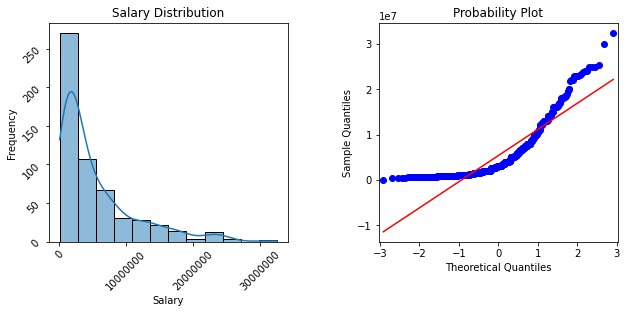

Skewness: 1.7619187361757083
Kurtosis: 2.8939784178229564


In [4]:
normality_check('Salary')

# Try different transformation of Salary

## Log transform salary

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


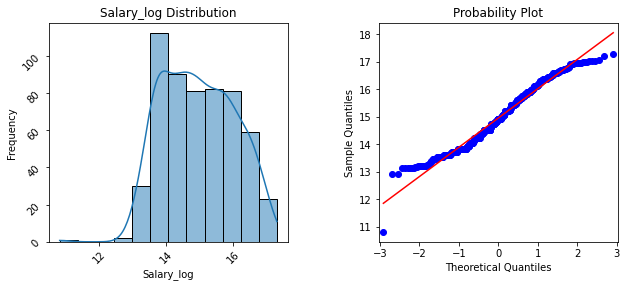

Skewness: 0.07343227286988813
Kurtosis: -0.6945940271829385


In [5]:
# natural log salaries
data_df['Salary_log'] = np.log(data_df['Salary'])
normality_check('Salary_log')

## Sqare root transform Salary

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


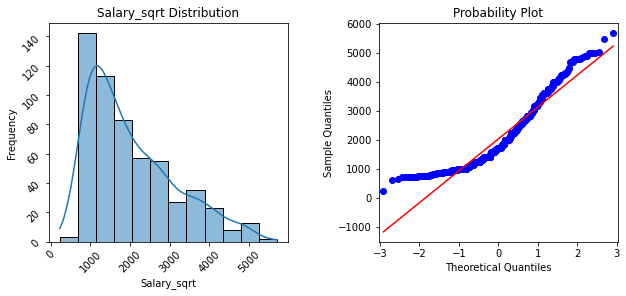

Skewness: 0.9428832710792775
Kurtosis: 0.09951659217031583


In [6]:
data_df['Salary_sqrt'] = data_df['Salary'] ** (1/2)
normality_check('Salary_sqrt')

# Box Cox Transformation

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


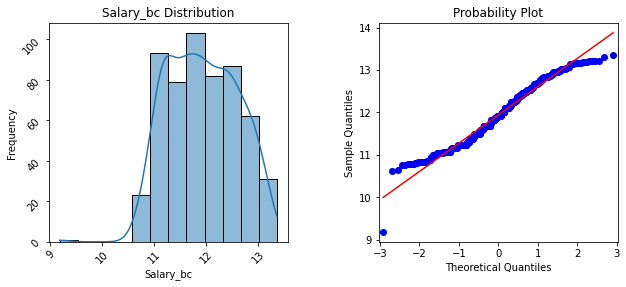

Skewness: 0.00710624334238819
Kurtosis: -0.610471467947999


In [7]:
xt, _ = stats.boxcox(data_df['Salary'])
data_df['Salary_bc'] = xt
normality_check('Salary_bc')

# Check normality of predictors

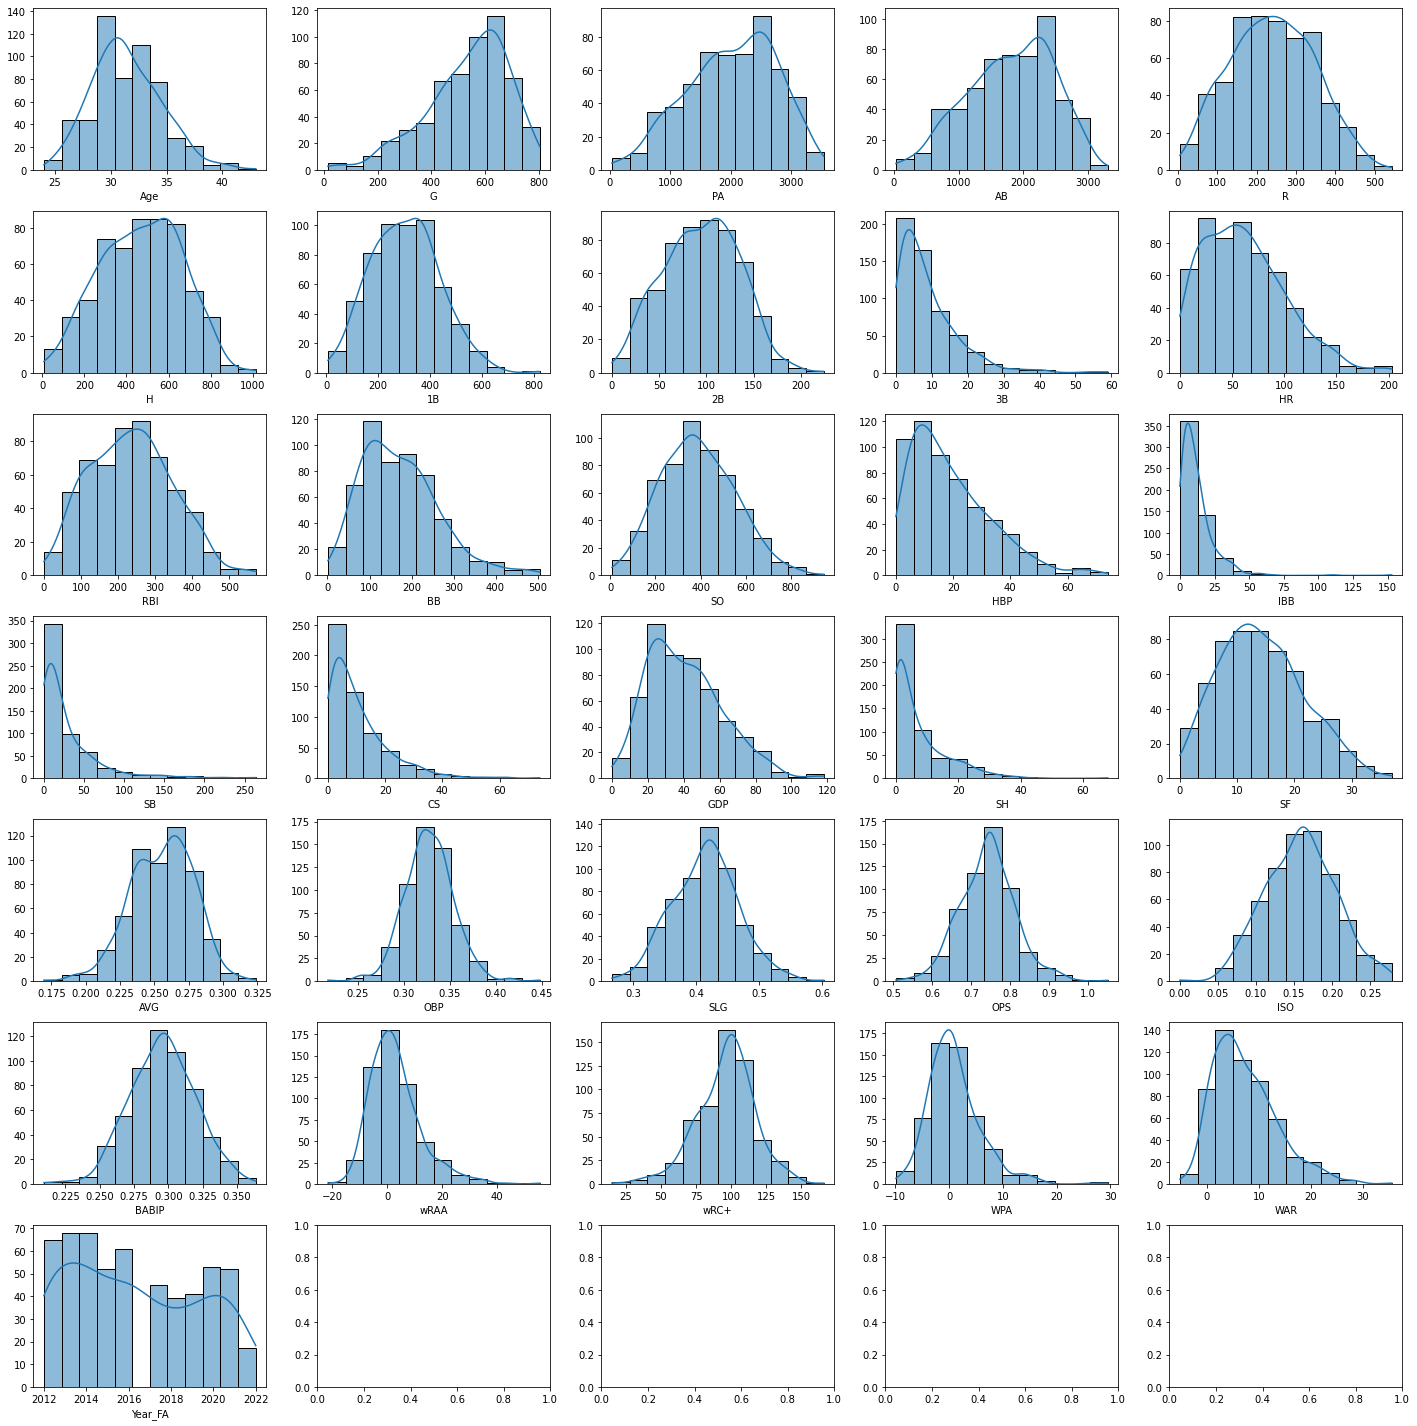

In [8]:
predictors = ['Age', 'G', 'PA', 'AB', 'R', 'H', '1B',
               '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'HBP', 'IBB', 'SB', 'CS',
               'GDP', 'SH', 'SF', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP',
               'wRAA', 'wRC+', 'WPA', 'WAR', 'Year_FA']

fig, ax = plt.subplots(7, 5)
fig.set_size_inches(20, 20)
fig.tight_layout(pad=2)

count = 0
for a in range(7):
    for b in range(5):
        try:
            sns.histplot(data=data_df[predictors[count]], ax=ax[a, b], bins=12, kde=True)
            ax[a, b].set(ylabel=None)
            count += 1
        except:
            pass

# Extremely non-normal vars: 3B, IBB, SB, CS, SH

### log transformation:

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


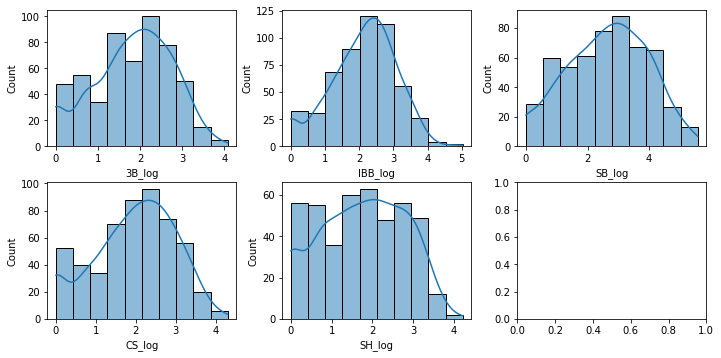

In [9]:
trans_list = ['3B', 'IBB', 'SB', 'CS', 'SH']

for i in trans_list:
    data_df[i+'_log'] = np.log(data_df[i])
    
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(10, 5)
fig.tight_layout(pad=1.5)
count = 0
for a in range(2):
    for b in range(3):
        try:
            sns.histplot(data=data_df[trans_list[count]+'_log'], ax=ax[a, b], bins=10, kde=True)
            count += 1
        except:
            pass

# Check outliers?
### Influence plot

In [10]:
data_df.iloc[[354]]

index  IDfg        Name  Age    G   PA   AB   R    H   1B  2B  3B  HR  \
354    354  1766  Laynce Nix   30  357  895  822  97  204  113  52   4  35   

     RBI  BB   SO  HBP  IBB  SB  CS  GDP  SH  SF       AVG       OBP  \
354  108  61  209    3    9   2   4   11   2   7  0.248175  0.307095   

          SLG    OPS      ISO     BABIP  wRAA  wRC+   WPA  WAR  Year_FA  \
354  0.448905  0.756  0.20073  0.288889  -0.2  33.6  0.45  2.7     2012   

     seasons_included     Salary  Salary_log  Salary_sqrt  Salary_bc  \
354                 5  1250000.0   14.038654  1118.033989  11.367942   

       3B_log   IBB_log    SB_log    CS_log    SH_log  
354  1.386294  2.197225  0.693147  1.386294  0.693147

In [11]:
data_df[data_df['seasons_included'] == 2]

index   IDfg               Name  Age   G   PA   AB   R   H  1B  2B  3B  \
193    193   8145         Eric Fryer   26  16   34   30   5   8   8   0   0   
200    200   5496  Francisco Peguero   25  35   46   45  10   9   7   1   0   
491    491   6962        Ryan Kalish   24  89  282  259  38  63  44  14   1   
504    504  14453     Scott Heineman   27  49  139  127  14  24  12   9   0   

     HR  RBI  BB  SO  HBP  IBB  SB  CS  GDP  SH  SF       AVG       OBP  \
193   0    0   4   8    0    1   1   1    0   0   0  0.266667  0.371429   
200   1    1   1   9    0    0   5   0    2   0   0  0.200000  0.217391   
491   4   29  18  64    1    0  13   3    9   2   2  0.243243  0.292857   
504   3   14  11  31    1    0   4   2    4   0   0  0.188976  0.258993   

          SLG       OPS       ISO     BABIP  wRAA  wRC+   WPA  WAR  Year_FA  \
193  0.266667  0.638095  0.000000  0.363636 -0.50  84.5 -0.24  0.2     2013   
200  0.288889  0.506280  0.088889  0.228571 -1.65  32.5  0.35  0.1     2014   
491  0.351351  0.644208  0.108108  0.305699 -3.65  64.5 -0.32 -0.5     2014   
504  0.330709  0.589701  0.141732  0.225806 -3.70  45.5 -1.30 -0.5     2021   

     seasons_included    Salary  Salary_log  Salary_sqrt  Salary_bc  3B_log  \
193                 2  515000.0   13.151922   717.635005  10.787720    -inf   
200                 2  550000.0   13.217674   741.619849  10.831297    -inf   
491                 2  550000.0   13.217674   741.619849  10.831297     0.0   
504                 2  595000.0   13.296317   771.362431  10.883300    -inf   

     IBB_log    SB_log    CS_log    SH_log  
193      0.0  0.000000  0.000000      -inf  
200     -inf  1.609438      -inf      -inf  
491     -inf  2.564949  1.098612  0.693147  
504     -inf  1.386294  0.693147      -inf

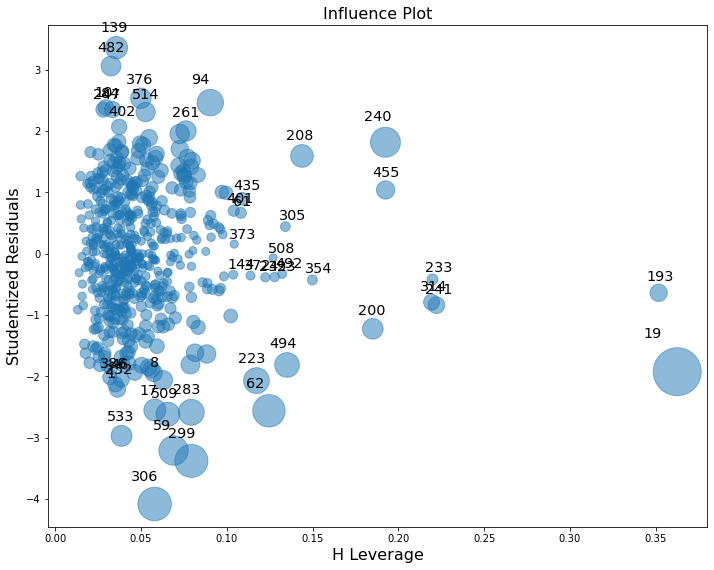

In [12]:
predictors = ['Age', 'G', 'PA', 'AB', 'R', 'H', '1B',
               '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'HBP', 'IBB', 'SB', 'CS',
               'GDP', 'SH', 'SF', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP',
               'wRAA', 'wRC+', 'WPA', 'WAR', 'Year_FA']


X = data_df[predictors]
y = data_df['Salary_sqrt']
model = sm.OLS(y, X).fit()

fig, ax=plt.subplots(figsize=(10,8))
sm.graphics.influence_plot(model, criterion="cooks", ax=ax, plot_alpha=0.5)
fig.tight_layout(pad=1.0)

In [13]:
ok = statsmodels.stats.outliers_influence.OLSInfluence(model).cooks_distance
ok = list(ok[0])
# df = pd.DataFrame(ok, columns=[cooks])
cooks = pd.DataFrame(ok, columns=['cooks'])
cooks = data_df[['index', 'IDfg']]
cooks.insert(2, 'cooks', pd.DataFrame(ok))

In [14]:
# cooks.sort_values(by='cooks', ascending=False)
cooks

index   IDfg     cooks
0        0   5677  0.001061
1        1    746  0.005904
2        2    746  0.000733
3        3    746  0.000151
4        4    746  0.000040
..     ...    ...       ...
556    556  11368  0.001011
557    557  11368  0.000143
558    558   2530  0.001840
559    559   8585  0.000157
560    560   2616  0.003631

[561 rows x 3 columns]

# Variables correlation matrix heatmap

In [15]:
vars_full = ['Age', 'G', 'PA', 'AB', 'R', 'H', '1B',
           '2B', '3B_log', 'HR', 'RBI', 'BB', 'SO', 'HBP', 'IBB_log', 'SB_log', 'CS_log',
           'GDP', 'SH_log', 'SF', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP',
           'wRAA', 'wRC+', 'WPA', 'WAR', 'Year_FA', 'Salary_sqrt']


dataCorr_df = data_df[vars_full]

In [16]:
corrmat = dataCorr_df.corr()

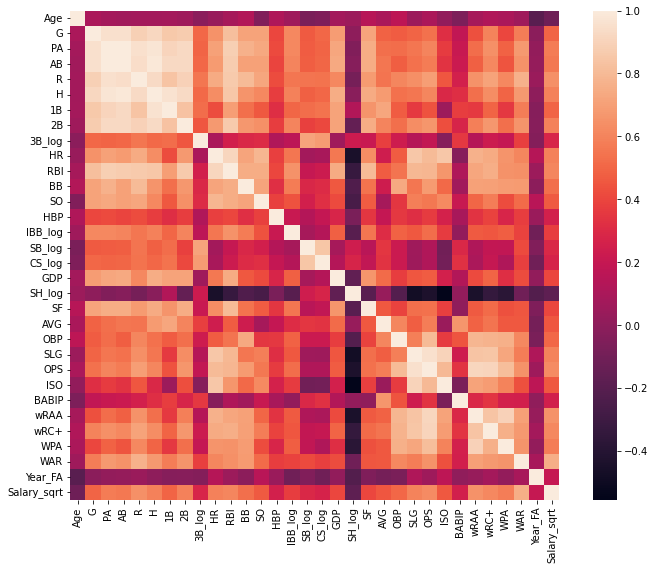

In [17]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

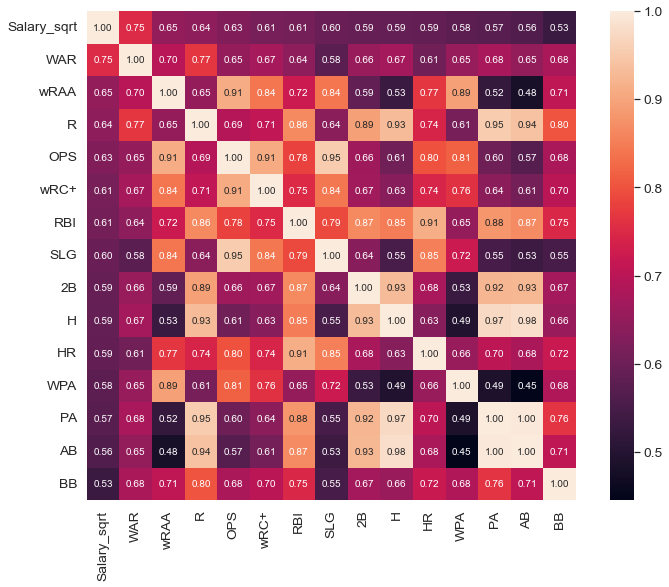

In [18]:
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Salary_sqrt')['Salary_sqrt'].index
cm = np.corrcoef(dataCorr_df[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(12, 9))

hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Eliminate variables that have obvious colinear relationship with others

## Predictors pairplot

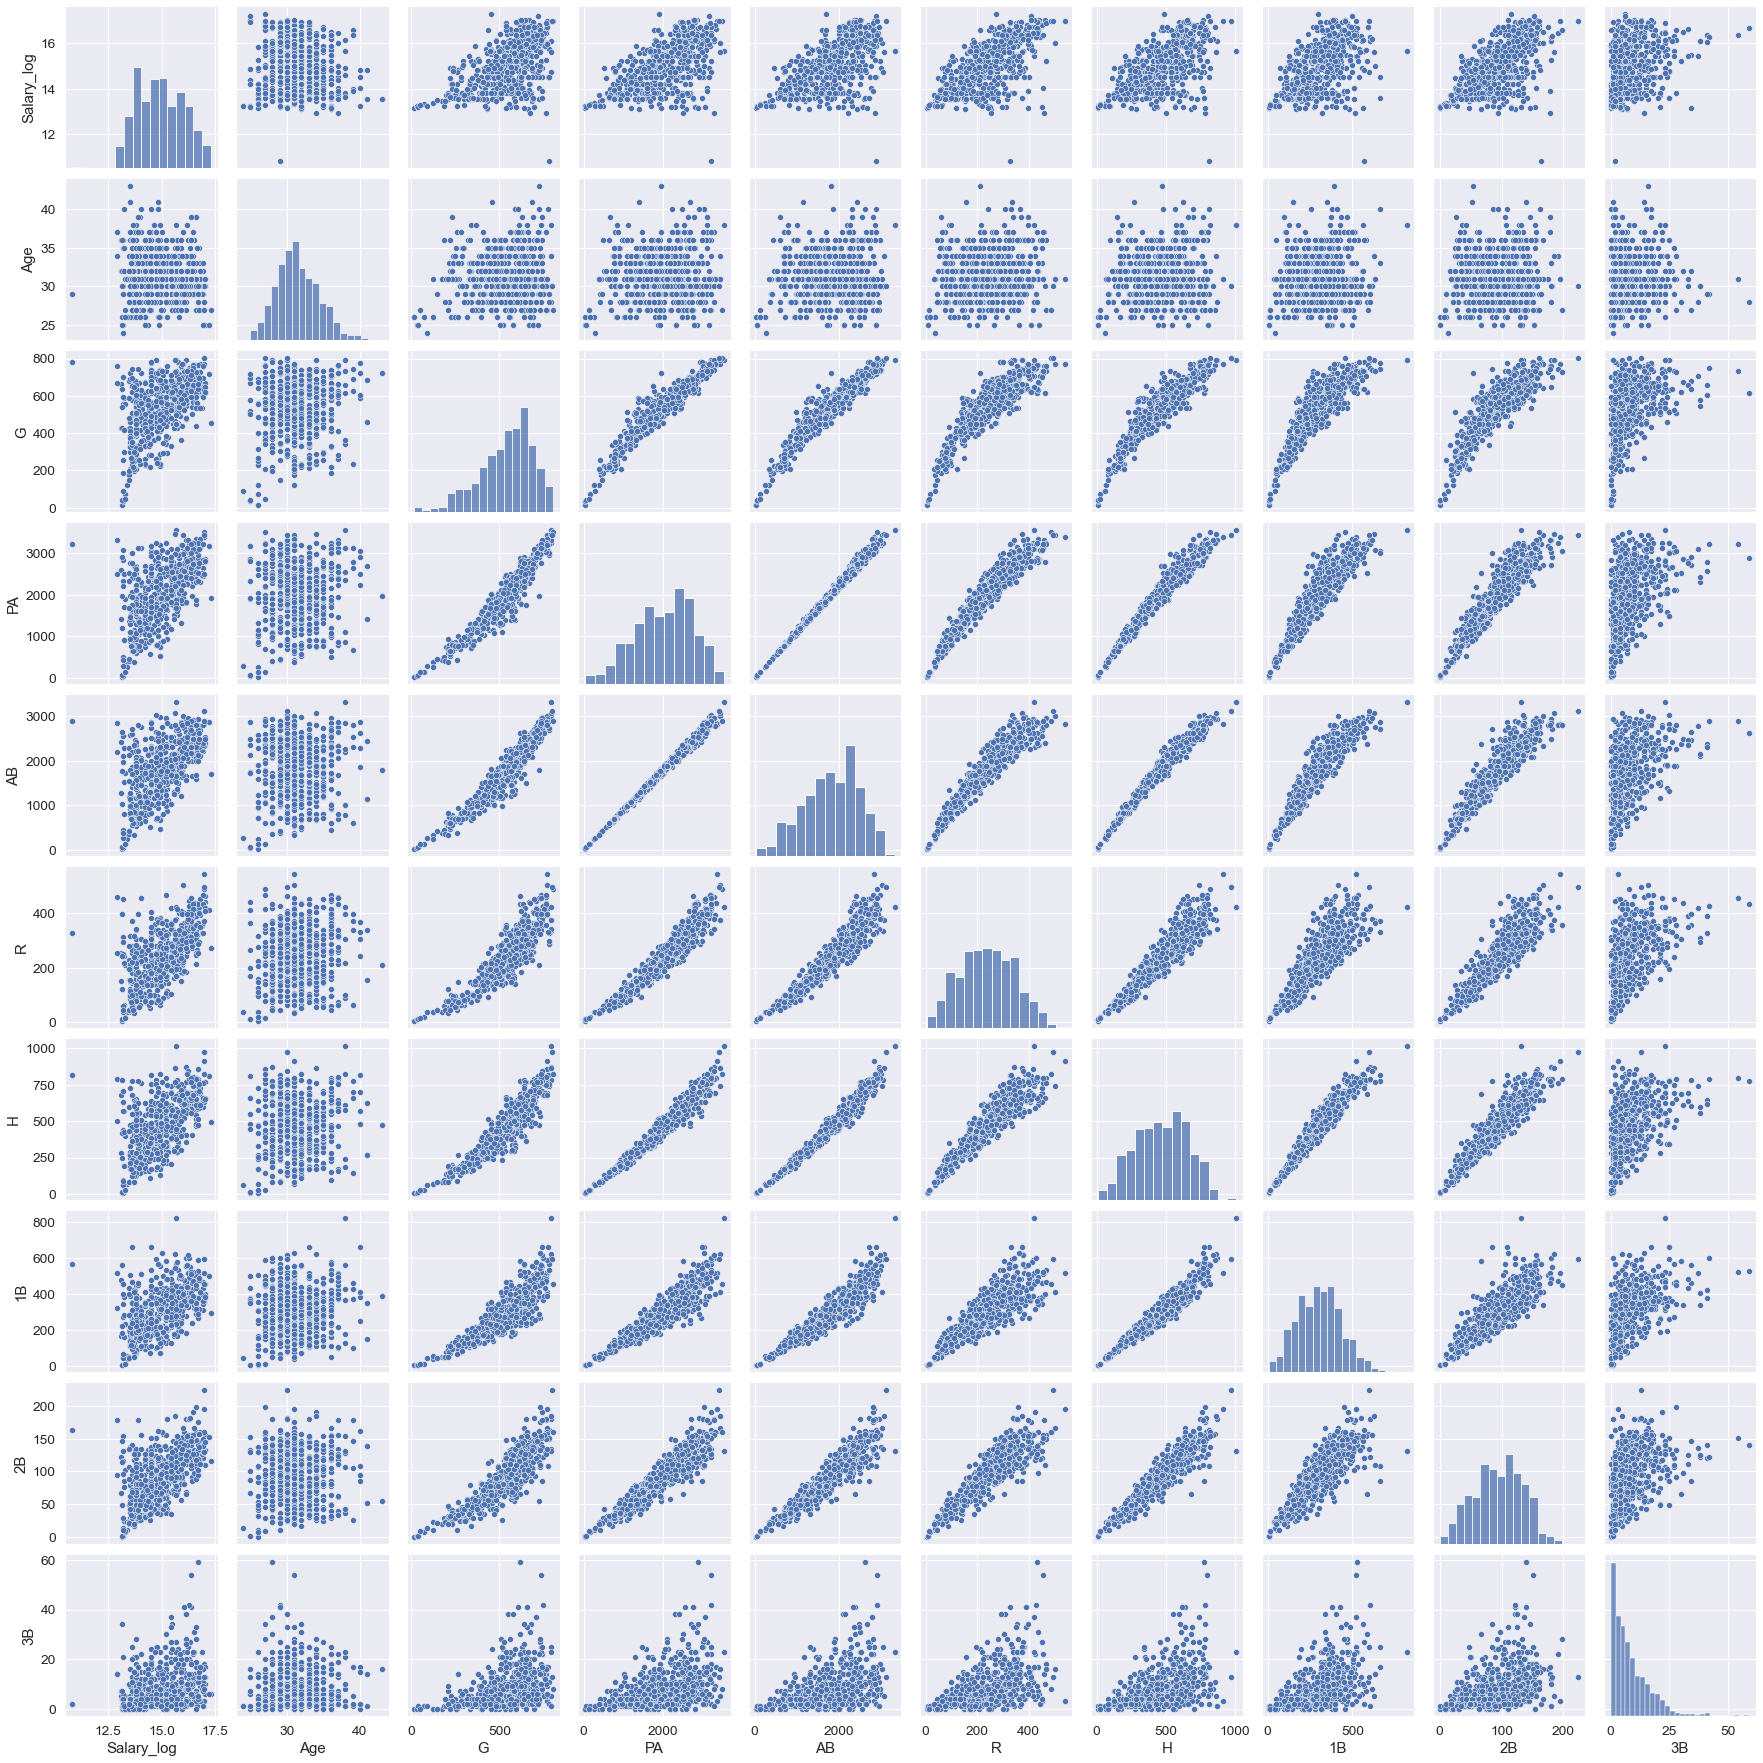

In [19]:
vars1 = ['Salary_log', 'Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B']
vars2 = ['Salary_log', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'GDP', 'HBP']
vars3 = ['Salary_log', 'SH', 'SF', 'IBB', 'AVG', 'OBP', 'SLG', 'Year_FA']
vars4 = ['Salary_log', 'BABIP', 'ISO', 'OPS', 'wRAA', 'wRC+', 'WPA', 'WAR']

sns.pairplot(data_df,vars=vars1);

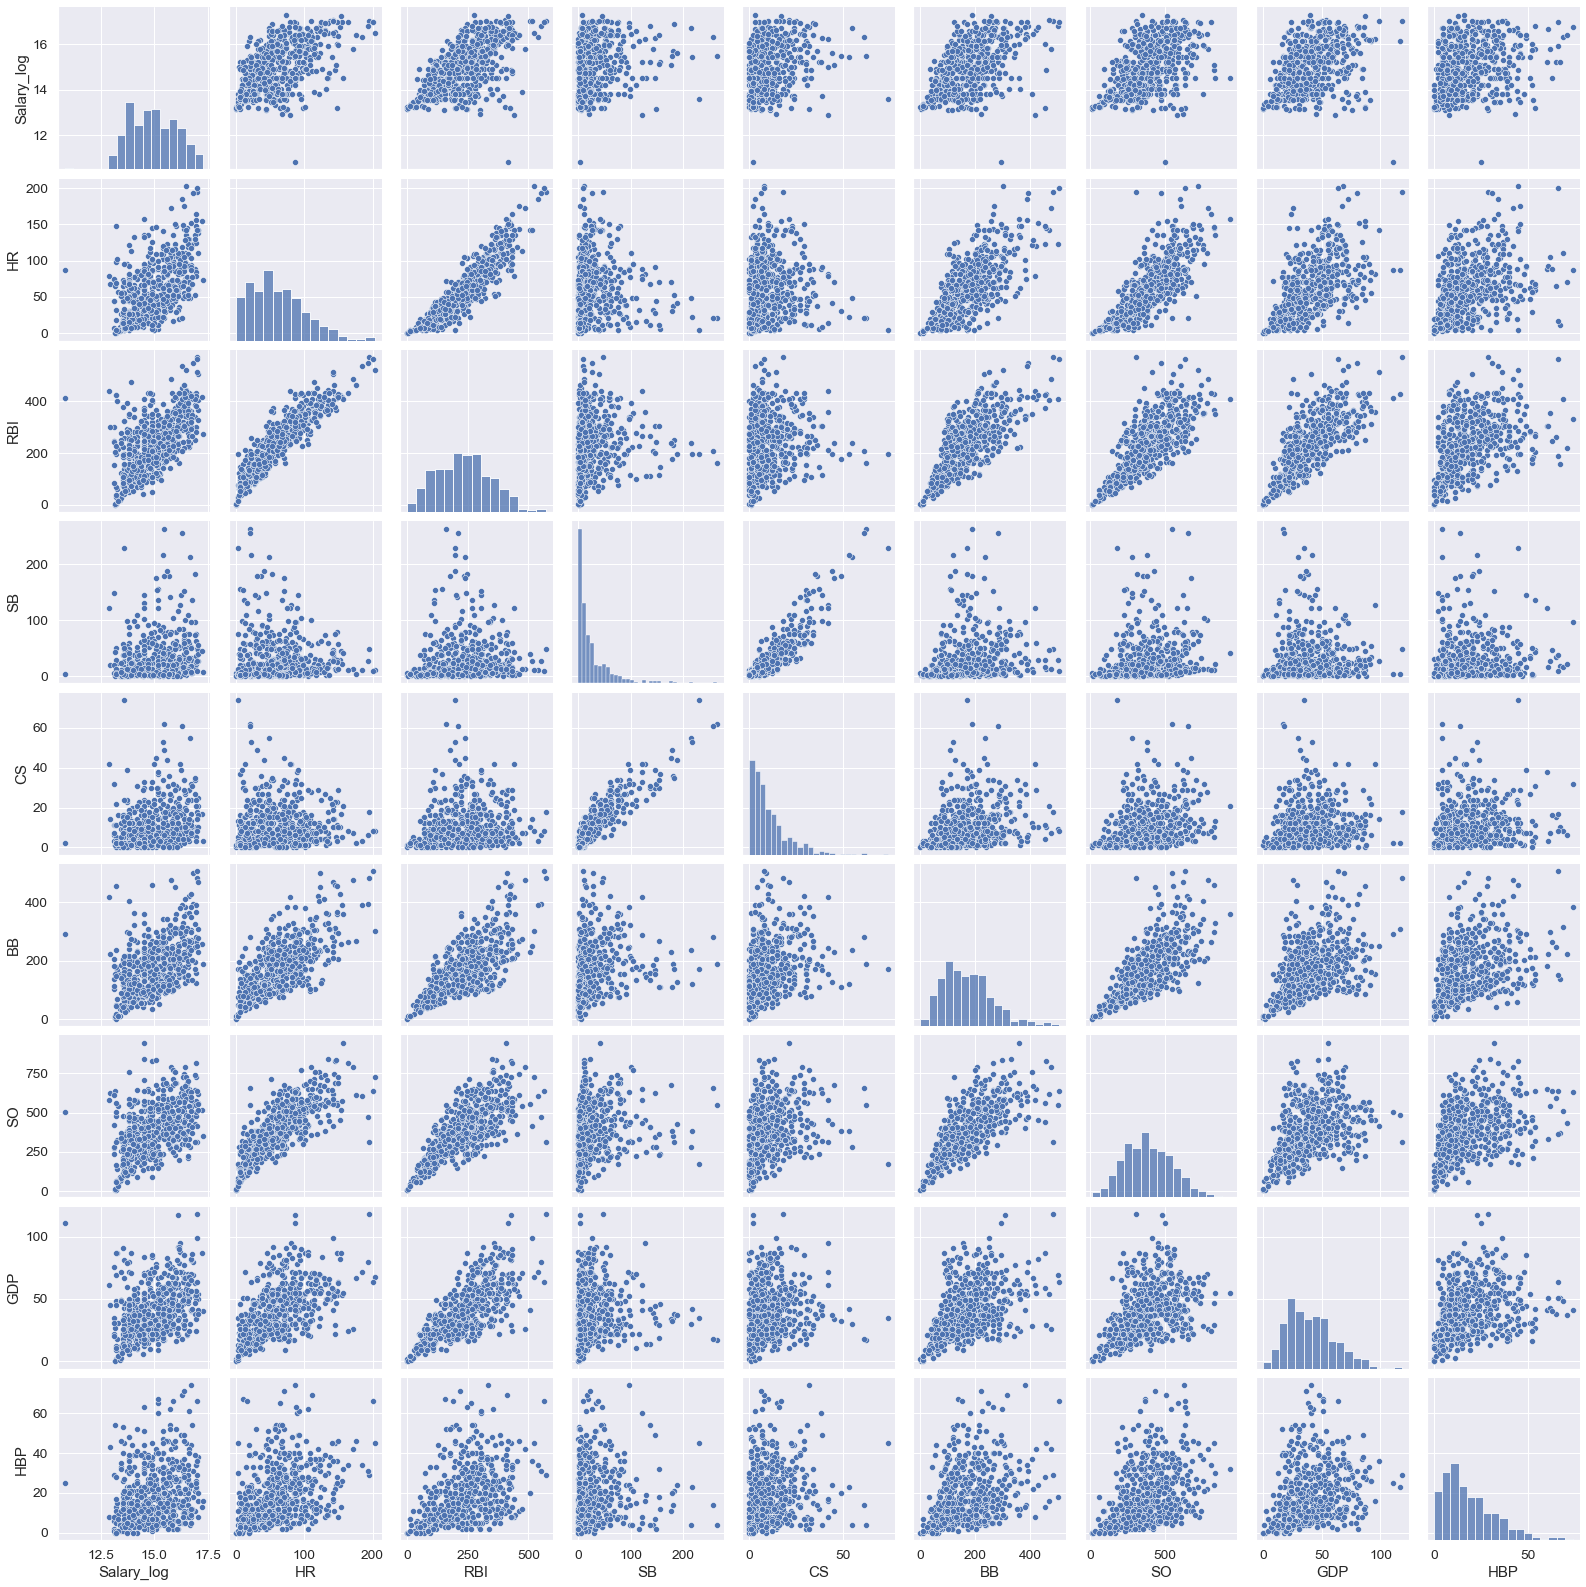

In [20]:
sns.pairplot(data_df,vars=vars2);

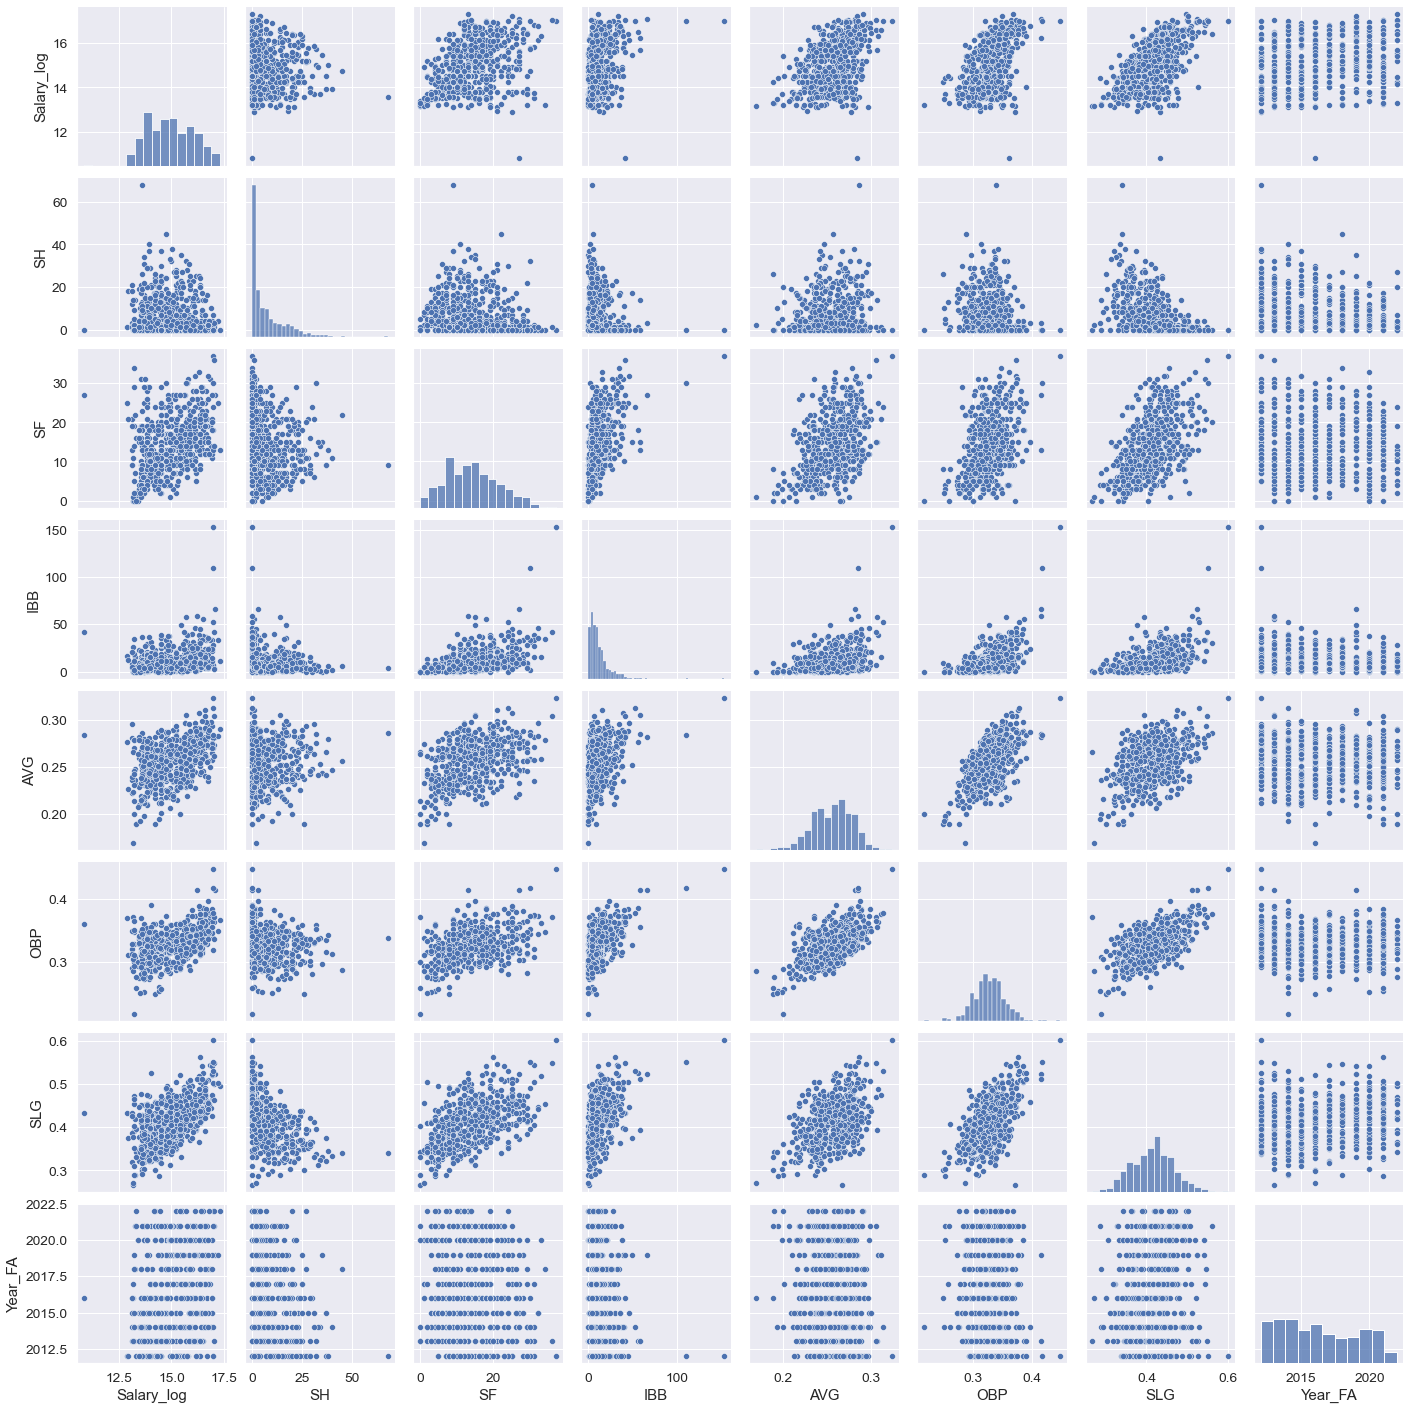

In [21]:
sns.pairplot(data_df,vars=vars3);

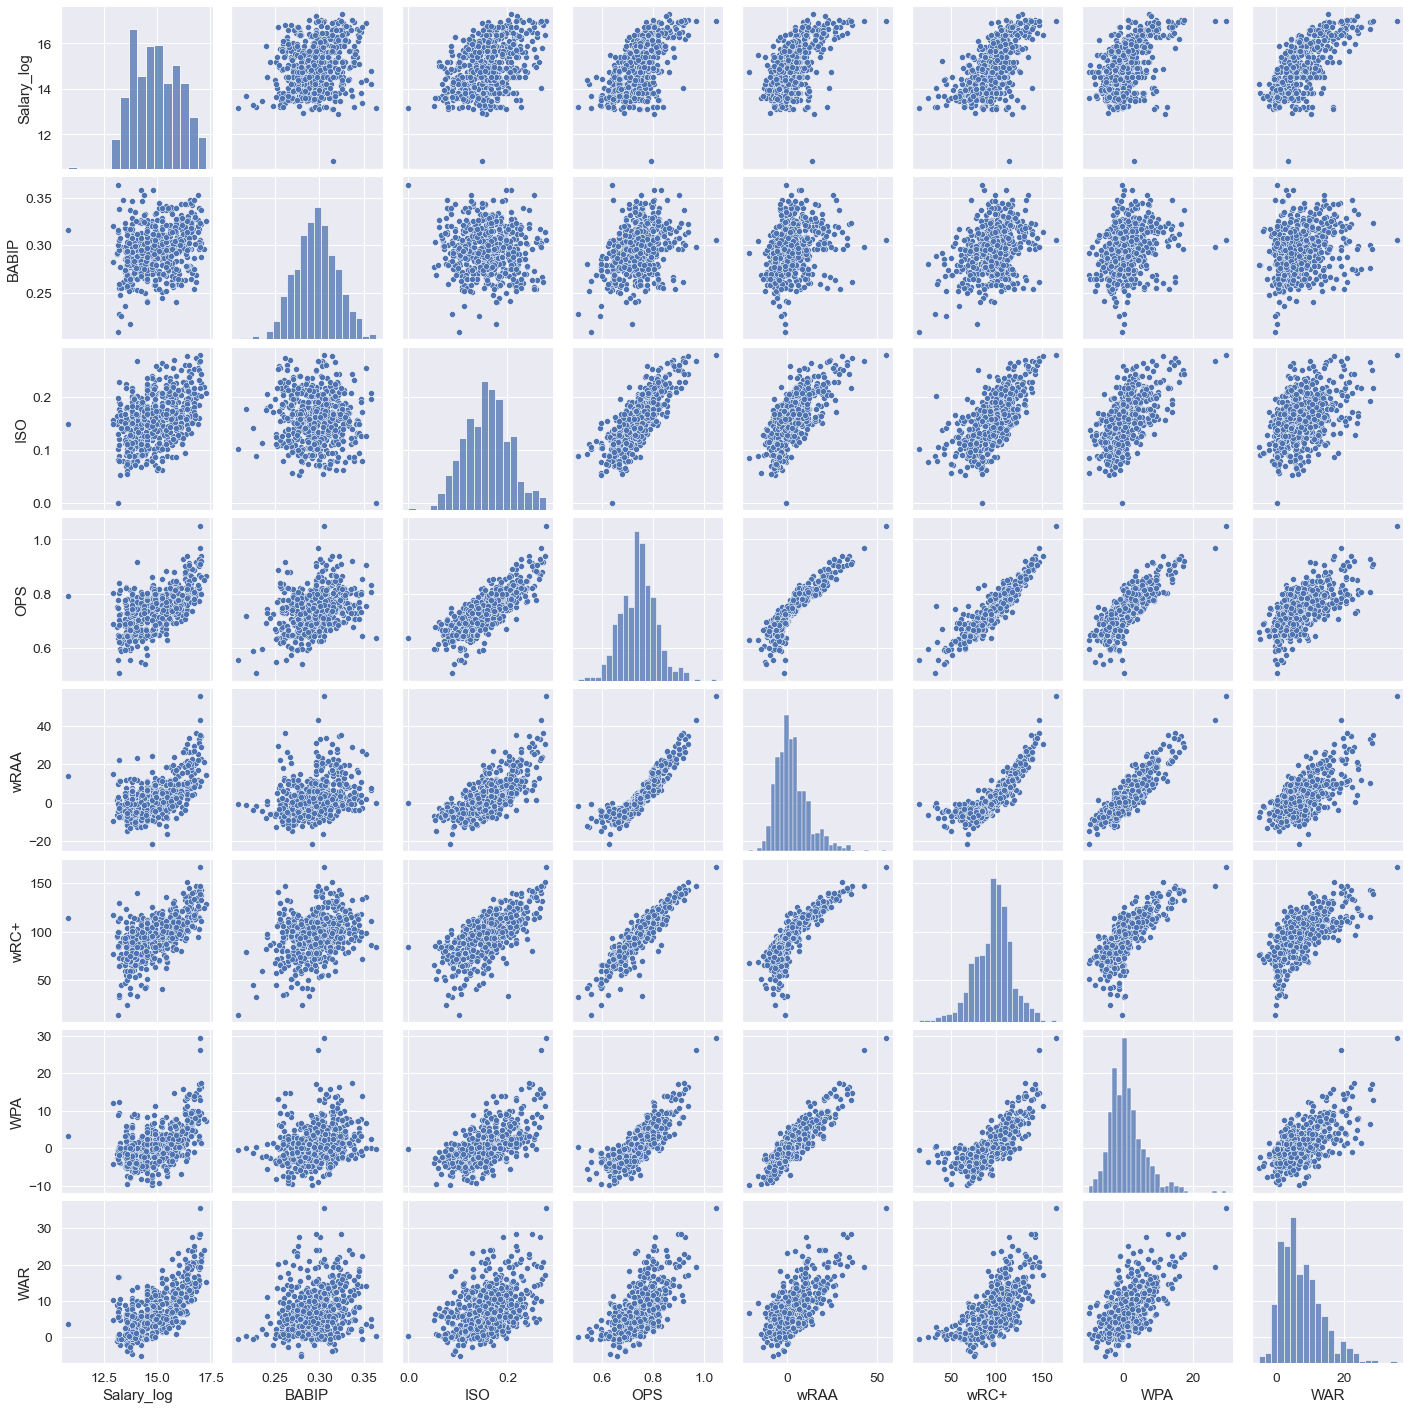

In [22]:
sns.pairplot(data_df,vars=vars4);

# Variable correlation matrix heatmap

In [23]:
X = data_df[predictors]
y = data_df['Salary_sqrt']

In [24]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Salary_sqrt   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     38.62
Date:                Wed, 02 Feb 2022   Prob (F-statistic):          2.96e-109
Time:                        12:15:05   Log-Likelihood:                -4413.6
No. Observations:                 561   AIC:                             8885.
Df Residuals:                     532   BIC:                             9011.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.02e+05   2.12e+04     -4.801      0.0

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


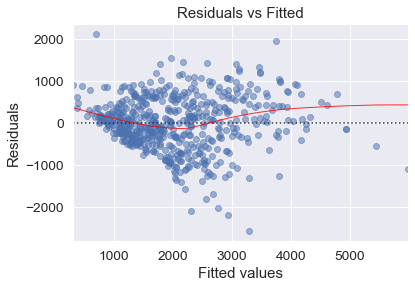

In [25]:
dataframe = pd.concat([X, y], axis=1)

# model values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = results.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = results.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

# Fitting and checking diagnostic plots of individual variables

In [26]:
dataframe.columns[-1]

'Salary_sqrt'

                            OLS Regression Results                            
Dep. Variable:            Salary_sqrt   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     725.6
Date:                Wed, 02 Feb 2022   Prob (F-statistic):          4.50e-103
Time:                        12:15:05   Log-Likelihood:                -4491.4
No. Observations:                 561   AIC:                             8987.
Df Residuals:                     559   BIC:                             8995.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1042.3228     47.907     21.757      0.0

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


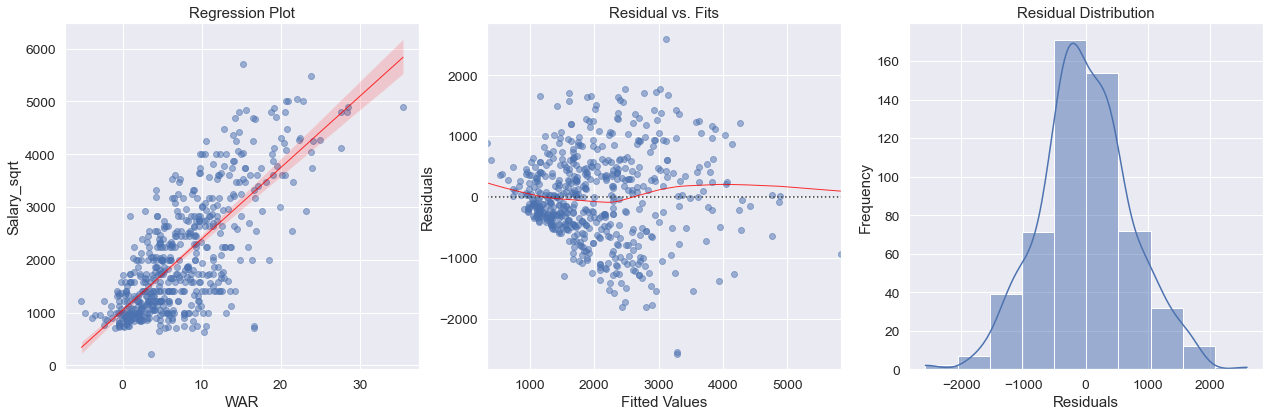

Skewness: 0.03846837886513014
Kurtosis: 0.387276069869106


In [27]:
var_name = 'WAR'
y_name = 'Salary_sqrt'

X = data_df[var_name]
y = data_df[y_name]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


dataframe = pd.concat([X, y], axis=1)

# # model values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid

fig2, ax2 = plt.subplots(1, 3, figsize=(18,6))
# fig.set_size_inches(10, 10)
fig2.tight_layout(pad=2)

# sns.set(rc={'figure.figsize':(10,14)})
sns.regplot(x=var_name, y=y_name, data=dataframe, ax=ax2[0], 
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax2[0].set(xlabel=var_name, ylabel=y_name, title='Regression Plot')
# residual vs fits plot
sns.residplot(model_fitted_y, y_name, ax=ax2[1] , data=dataframe,
                lowess=True,
                scatter_kws={'alpha': 0.5},
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax2[1].set(xlabel='Fitted Values', ylabel='Residuals', title='Residual vs. Fits')


# residual histogram
sns.histplot(data=model_residuals, ax=ax2[2], bins=10, kde=True)
ax2[2].set(xlabel='Residuals', ylabel='Frequency', title='Residual Distribution')
plt.show()

print(f"Skewness: {model_residuals.skew()}")
print(f"Kurtosis: {model_residuals.kurt()}")

In [28]:
# data_df['WAR_avg'] = raw_data['WAR'] / raw_data['seasons_included']

# square transform WAR with added constant term

In [29]:
data_df['WAR2'] = (data_df['WAR'] + (1-data_df['WAR'].min())) ** 2
data_df['WAR2_log'] = np.log(data_df['WAR2'])

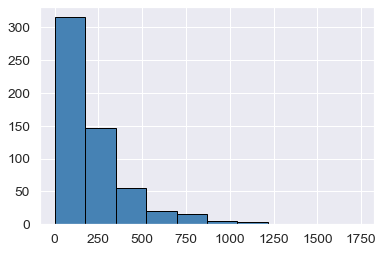

In [30]:
plt.hist(data_df['WAR2'], color='steelblue', edgecolor='black')
plt.show()

In [31]:
X = data_df[['WAR', 'WAR2']]
y = data_df['Salary_sqrt']
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Salary_sqrt   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     363.0
Date:                Wed, 02 Feb 2022   Prob (F-statistic):          1.07e-101
Time:                        12:15:06   Log-Likelihood:                -4491.1
No. Observations:                 561   AIC:                             8988.
Df Residuals:                     558   BIC:                             9001.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1052.2578     49.369     21.314      0.0

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Check multicollinearity

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


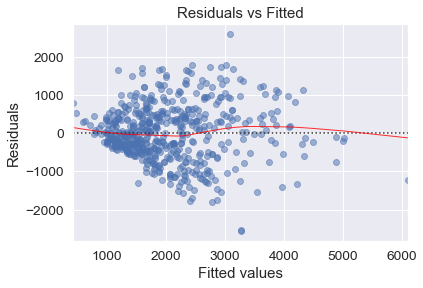

In [32]:
df = pd.concat([X, y], axis=1)

# model values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = results.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = results.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=df,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

In [33]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# variables = model.exog
# vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# for i in range(len(predictors)):
#     print(f"{predictors[i]}: {vif[i]}")
    